## Instance of TD-IDF and QueryEngine

* **TD-IDF**: implement tf-idf algorithms
* **QueryEngine**: Implement query function based on tf-idf and recommend the related movies
    * *text_preprocessing(doc_all, remove_stopwords=False, selective_POS=[])*
        - `doc_all` (list of dict): the token list of each movie corpus data
        - `remove_stopwords` (boolean): whether filter the stopwords
        - `selective_POS` (string of list): add the POS tag into the list, and the function will filter tokens not in the pos list

In [1]:
import math
import numpy as np

class TF_IDF():
    def bag_of_word(self, token_doclist):
        bag_words = list()
        for key in doc_all.keys():
            bag_words += doc_all[key]
        
        bag_words = set(bag_words)
        return bag_words
    
    def tf(self, term, token_doc):
        tf = token_doc.count(term)/len(token_doc)
        return tf

    # create function to calculate how many doc contain the term 
    def numDocsContaining(self, word, token_doclist):
        doccount = 0
        for doc_token in token_doclist:
            if doc_token.count(word) > 0:
                doccount +=1
        return doccount
    
    # create function to calculate  Inverse Document Frequency in doclist - this list of all documents
    def idf(self, word, token_doclist):
        n = len(token_doclist)
        df = self.numDocsContaining(word, token_doclist)
        return math.log10(n/df)
    
    # calculate idf for every word in bag_words
    def bow_idf(self, token_doclist):
        bow = self.bag_of_word(token_doclist)
        
        bag_words_idf = dict()
        
        bag_words_len = len(bow)
        bag_word_10 = round(bag_words_len/10,0)
        print("the number of term in bag_word", bag_words_len)
        print("Start idf processing")
        
        i=0
        for word in bow:
            i+=1
            bag_words_idf[word] = self.idf(word, token_doclist)
            
            if (i%bag_word_10==0):print("finish %s idf processing" %(str(round(i*10/bag_word_10))+"%"))
            bag_words_idf[word]= self.idf(word,doc_all.values())
        
        print("finish idf processing")
        return bag_words_idf

    # define a function to do cosine normalization a data dictionary
    def cos_norm(self, dic): # dic is distionary data structure
        dic_norm = {}
        factor = 1.0/np.sqrt(sum([np.square(i) for i in dic.values()]))
        for k in dic:
            dic_norm[k] = dic[k]*factor
        return dic_norm

    # create function to calculate normalize tfidf 
    def compute_tfidf(self, token_doc, bag_words_idf):
        tfidf_doc = {}
        for word in set(token_doc):
            tfidf_doc[word] = self.tf(word,token_doc) * bag_words_idf[word]   
        tfidf_norm = self.cos_norm(tfidf_doc)
        return tfidf_norm
    
    def tfidf(self, token_doclist, bag_words_idf):
        tfidf = {}
        
        for doc in doc_all.keys():
            tfidf[doc]= self.compute_tfidf(doc_all[doc], bag_words_idf)
        
        finish_time = datetime.now(timezone('Asia/Taipei')).strftime("%H:%M:%S")
        
        print("finish tfidf processing at", finish_time)
        return tfidf

    # create normalize term frequency
    def tf_norm(self, token_doc):
        tf_norm={}
        for term in token_doc:
            tf = token_doc.count(term)/len(token_doc)
            tf_norm[term] = tf
        tf_max = max(tf_norm.values())
        for term, value in tf_norm.items():
            tf_norm[term] = 0.5 + 0.5*value/tf_max
        return tf_norm

    def compute_tfidf_query(self, query_token, bag_words_idf):
        tfidf_query = {}
        tf_norm_query = self.tf_norm(query_token)
        for term, value in tf_norm_query.items():
            tfidf_query[term] = value * bag_words_idf[term]
        return tfidf_query

In [2]:
import os
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from datetime import datetime
from pytz import timezone
import pandas as pd
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

now = datetime.now(timezone('Asia/Taipei'))
nltk.download('punkt')


class QueryEngine(TF_IDF):
    def __init__(self):
        self.stopwords = self._load_stopwords()
        
    def _load_stopwords(self):
        sw = set(stopwords.words('english'))
        my_stopwords = [".", ",", "'ll", "'re", "'s", "!", "'ve", ",', ", "''", "``", "--", "n't", "?"]
        sw = list(sw) + my_stopwords
        return sw
        
    def load_data_and_tokenize(self, file_path):
        doc_all = dict()
        
        for filename in os.listdir(file_path):
            fileExtension = filename.split(".")[-1]
            if fileExtension == "txt":
                text = open(file_path + filename).read()
                tokens = nltk.word_tokenize(text)
                token_filtered = [w.lower() for w in tokens if w.isalpha()]
                doc_all[filename[:-4]] = token_filtered
        return doc_all
    
    def text_preprocessing(self, doc_all, remove_stopwords=False, selective_POS=[]):
        if remove_stopwords == True:
            for key in doc_all.keys():
                doc_all[key] = [w for w in doc_all[key] if w not in self.stopwords]
                
        if selective_POS != []:
            for key in doc_all.keys():
                pos_tokens_list = nltk.pos_tag(doc_all[key])
                
                selective_pos_tkns = []
                for tkn in pos_tokens_list:
                    if tkn[1] in selective_POS:
                        selective_pos_tkns.append(tkn[0])

                doc_all[key] = selective_pos_tkns
        return doc_all
    
    def tfidf_query(self, doc_all, bow_idf, query, topK=10):
        query_token_raw = nltk.word_tokenize(query)
        query_token = [term for term in query_token_raw if term in qe.bag_of_word(doc_all)]
        query_result = self.compute_tfidf_query(query_token, bow_idf) # calculate tfidf for query text
        
        # add tfidf of query text to tfidf of all doc and convert to dataframe
        tfidf = self.tfidf(doc_all, bow_idf)
        tfidf["query"] = query_result

        
        tfidf_df = pd.DataFrame(tfidf).transpose()
        tfidf_df= tfidf_df.fillna(0) # replace all NaN by zero
        
        cosine_sim = {}
        for row in tfidf_df.index:
            if row != "query":
                cosine_sim[row]= 1-cosine(tfidf_df.loc[row],tfidf_df.loc["query"])

        # the top k relevant document
        cosine_sim_topK = dict(sorted(cosine_sim.items(), key=lambda item: item[1], reverse=True)[:topK])
        
        return cosine_sim_topK
    
    def show_plot(self, query_result, isSave=False, file_name=''):
        data = query_result
        plt.barh(range(len(data)), list(data.values()), align='center', alpha=0.8)
        plt.yticks(range(len(data)), list(data.keys())) # label for y axis
        plt.xlabel('Smimilarity score')
        plt.ylabel('Course')

        # save graph
        if isSave:
            if not file_name:
                file_name = 'barchart'
            plt.savefig(file_name+".png", bbox_inches='tight', dpi=600)
            
        plt.show()

[nltk_data] Downloading package punkt to /Users/jensonsu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### (b) without feature selection

In [3]:
qe = QueryEngine()

doc_all = qe.load_data_and_tokenize('movies_synopsis/')
bow_idf = qe.bow_idf(doc_all.values())

the number of term in bag_word 23885
Start idf processing
finish 10% idf processing
finish 20% idf processing
finish 30% idf processing
finish 40% idf processing
finish 50% idf processing
finish 60% idf processing
finish 70% idf processing
finish 80% idf processing
finish 90% idf processing
finish 100% idf processing
finish idf processing


finish tfidf processing at 21:37:34
{'In the Mood for Love (2000)': 0.04942198684308974, 'Cinema Paradiso (1988)': 0.0385791014468162, 'Oldboy (2003)': 0.029868813671959704, 'Hachi_ A Dog_s Tale (2009)': 0.02053368803751121, 'PK (2014)': 0.018155635829057437, 'Memento (2000)': 0.017433973952850512, 'Children of Heaven (1997)': 0.016313515745064233, 'City of God (2002)': 0.016193535042648532, 'The Green Mile (1999)': 0.013793802392584875, 'Forrest Gump (1994)': 0.012222308729605835}


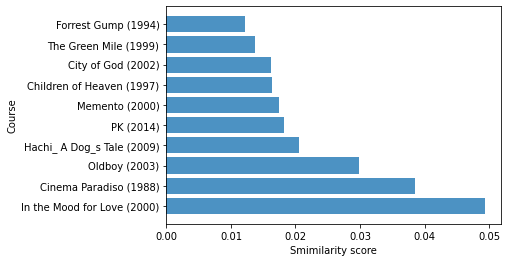

In [7]:
query = "love and lies movie"
tfidf_query_result = qe.tfidf_query(doc_all, bow_idf, query)
print(tfidf_query_result)

qe.show_plot(tfidf_query_result, isSave=True, file_name='barchart')

### (c) feature selection

In [5]:
doc_all = qe.load_data_and_tokenize('movies_synopsis/')

doc_all_feature = qe.text_preprocessing(doc_all, remove_stopwords=True, selective_POS=['NN','NNS', 'NNP', 'NNPS', 'JJ'])
bow_idf_feature = qe.bow_idf(doc_all_feature.values())

the number of term in bag_word 18800
Start idf processing
finish 10% idf processing
finish 20% idf processing
finish 30% idf processing
finish 40% idf processing
finish 50% idf processing
finish 60% idf processing
finish 70% idf processing
finish 80% idf processing
finish 90% idf processing
finish 100% idf processing
finish idf processing


finish tfidf processing at 21:37:41
{'In the Mood for Love (2000)': 0.042137660069727856, 'Cinema Paradiso (1988)': 0.03694920966838744, 'PK (2014)': 0.025949691830797983, 'Oldboy (2003)': 0.023062456294986045, 'Tokyo Story (1953)': 0.021486144715952227, 'Memento (2000)': 0.01793460213677367, 'Hachi_ A Dog_s Tale (2009)': 0.013825611298418194, 'Dead Poets Society (1989)': 0.0131323313346835, 'The Green Mile (1999)': 0.011060067522167594, 'City of God (2002)': 0.010966067508138555}


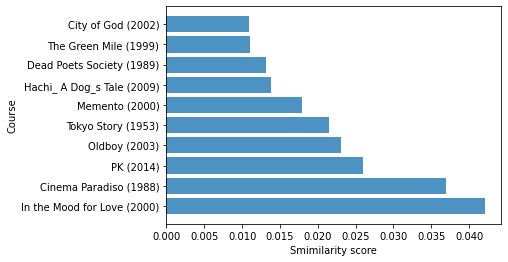

In [8]:
query = "love and lies movie"
tfidf_query_result = qe.tfidf_query(doc_all_feature, bow_idf_feature, query)
print(tfidf_query_result)

qe.show_plot(tfidf_query_result, isSave=True, file_name='barchart_after_selection')